In [1]:
# ==========================================
# ACTIVE LEARNING LOOP: THE OSCILLATOR HUNT
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import copy
import sys
import os
import pickle
from tqdm import tqdm  # <--- CHANGED: Use standard text bar (safer)

# 1. SETUP PATHS & IMPORTS
# Allow importing from the current folder and parent
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from active_learning_loop._lab import VirtualLab
from active_learning_loop._designer import ExperimentDesigner
from active_learning_loop._learner import Learner

In [ ]:
# ==========================================
# STEP A: LOAD TOPOLOGY (The Circuit Structure)
# ==========================================
print(">> [Step A] Loading Circuit Topology from GCAD Results...")

# 1. PATH FIX
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
miner_dir = os.path.join(parent_dir, 'circuits_miner')

if miner_dir not in sys.path:
    sys.path.append(miner_dir)

try:
    import define_circuit 
    print("   [System] Successfully linked 'define_circuit' module for unpickling.")
except ImportError:
    print("   [Warning] Could not import define_circuit directly. Unpickling might fail.")

# 2. FIND RESULTS
MINER_RESULTS_ROOT = os.path.join(miner_dir, "results")

if not os.path.exists(MINER_RESULTS_ROOT):
    raise FileNotFoundError(f"Could not find miner results at {MINER_RESULTS_ROOT}")

all_subdirs = [
    os.path.join(MINER_RESULTS_ROOT, d) 
    for d in os.listdir(MINER_RESULTS_ROOT) 
    if os.path.isdir(os.path.join(MINER_RESULTS_ROOT, d))
]

z1z2_runs = [d for d in all_subdirs if "Z1Z2" in d]
if not z1z2_runs:
    z1z2_runs = all_subdirs 

if not z1z2_runs:
    raise FileNotFoundError("No Miner results found! Cannot load topology.")

latest_subdir = max(z1z2_runs, key=os.path.getmtime)
print(f"   Loading topology source: {latest_subdir}")

# 3. LOAD PICKLES
try:
    winner_pop = pd.read_pickle(f"{latest_subdir}/final_population.pkl")
    winner_df = pd.read_pickle(f"{latest_subdir}/final_objectives_df.pkl")
except Exception as e:
    print(f"   [Error] Failed to load pickle files: {e}")
    print("   [Hint] Ensure 'define_circuit.py' is inside 'circuits_miner'.")
    raise

# 4. EXTRACT CIRCUIT
winner_df['circuit_object'] = [ind[0] for ind in winner_pop]

if 'prominence_rel' in winner_df.columns:
    winner_df['abs_prom'] = winner_df['prominence_rel'].abs()
    best_row = winner_df.sort_values('abs_prom', ascending=False).iloc[0]
else:
    best_row = winner_df.iloc[0]

target_circuit = best_row['circuit_object']

print(f"   [Success] Loaded Topology: {target_circuit.edge_list}")
print(f"   [Info] Nominal Doses: {target_circuit.dose}")


>> [Step A] Loading Circuit Topology from GCAD Results...
   [System] Successfully linked 'define_circuit' module for unpickling.
   Loading topology source: c:\Users\KuangQi\Desktop\GCAD-SDL\GCAD-SDL\Experimental Design\circuits_miner\results\Miner_Z1Z2_DsRed_2026-02-11
   [Success] Loaded Topology: [('P1', 'Z1'), ('P1', 'I2'), ('Z1', 'Rep'), ('Z1', 'I2'), ('Z1', 'Z1'), ('I2', 'Z1'), ('I2', 'Rep')]
   [Info] Nominal Doses: {'Rep': 200, 'I2': 45, 'Z1': 75}


In [ ]:

# ==========================================
# STEP B: LOAD PARAMETERS (The Prior Belief)
# ==========================================
print("\n>> [Step B] Loading Parameter Ensemble & Physics...")

# 1. Load the Learning Data
DATA_PATH = "active_learning_data.pkl" 

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "rb") as f:
        data = pickle.load(f)
    print(f"   [Success] Loaded {len(data['parameters'])} parameter sets.")
else:
    raise FileNotFoundError(f"Could not find {DATA_PATH}. Please run the 'Save Data' cell in your previous notebook.")

# 2. Load Nominal Promoter Parameters
promo_path = os.path.join(miner_dir, "promo.pkl")

if os.path.exists(promo_path):
    with open(promo_path, "rb") as f:
        nominal_promo = pickle.load(f)
    print("   [Success] Loaded nominal promoter parameters (promo.pkl).")
else:
    print("   [Warning] Could not find promo.pkl. Abolish.")
    raise KeyboardInterrupt




>> [Step B] Loading Parameter Ensemble & Physics...
   [Success] Loaded 200 parameter sets.
   [Success] Loaded nominal promoter parameters (promo.pkl).


In [ ]:
# ==========================================
# STEP C: CONFIGURATION
# ==========================================
N_CYCLES = 5                # Experiments to run
SECRET_INDEX = 65           # The "Hidden Truth" (Oscillator)
SELECTION_RATIO = 0.2       # Keep top 20%
PERTURBATION = 0.1          # Mutate by 10%
NOISE_LEVEL = 0.02          # 2% Lab Noise



In [ ]:
# ==========================================
# STEP D: INITIALIZE 
# ==========================================
print(f"\n>> [Hidden Mode] Initializing Virtual Lab with Secret Mutant #{SECRET_INDEX}...")

# 1. Extract Secret Parameters
true_params = data["parameters"][SECRET_INDEX]

if "promo_params" in data and data["promo_params"][SECRET_INDEX] is not None:
    true_promo_params = data["promo_params"][SECRET_INDEX]
else:
    true_promo_params = nominal_promo

# 2. Initialize Lab
lab = VirtualLab(
    topology=target_circuit,
    true_params=true_params,
    true_promo_params=true_promo_params,
    # ref_val=66.60528765956212, 
    noise_level=NOISE_LEVEL
)

# 3. Initialize AL (Designer & Learner)
current_ensemble = copy.deepcopy(data["parameters"])

if "promo_params" in data and data["promo_params"] is not None:
    current_promos = copy.deepcopy(data["promo_params"])
else:
    current_promos = [nominal_promo] * len(current_ensemble)

designer = ExperimentDesigner(target_circuit)
learner = Learner(target_circuit, selection_ratio=SELECTION_RATIO, perturbation_scale=PERTURBATION)



>> [Hidden Mode] Initializing Virtual Lab with Secret Mutant #65...



>> STARTING ACTIVE LEARNING LOOP...


Cycle 1/5: Updating Beliefs...:   0%|          | 0/5 [06:43<?, ?it/s]


>> Cycle 1: Requesting Dosage 1.8x (Max Disagreement)
   [Learner] Assessing 200 parameter sets against experimental data...
   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.3565e-04


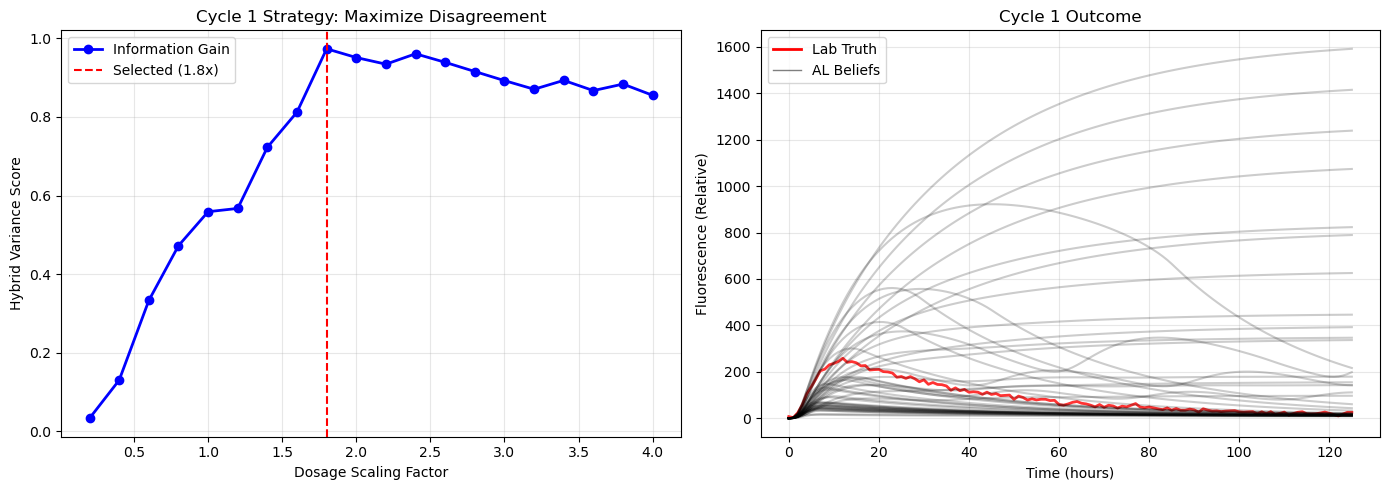

Cycle 2/5: Updating Beliefs...:  20%|██        | 1/5 [13:30<28:23, 426.00s/it]


>> Cycle 2: Requesting Dosage 0.6x (Max Disagreement)
   [Learner] Assessing 200 parameter sets against experimental data...
   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.7365e-04


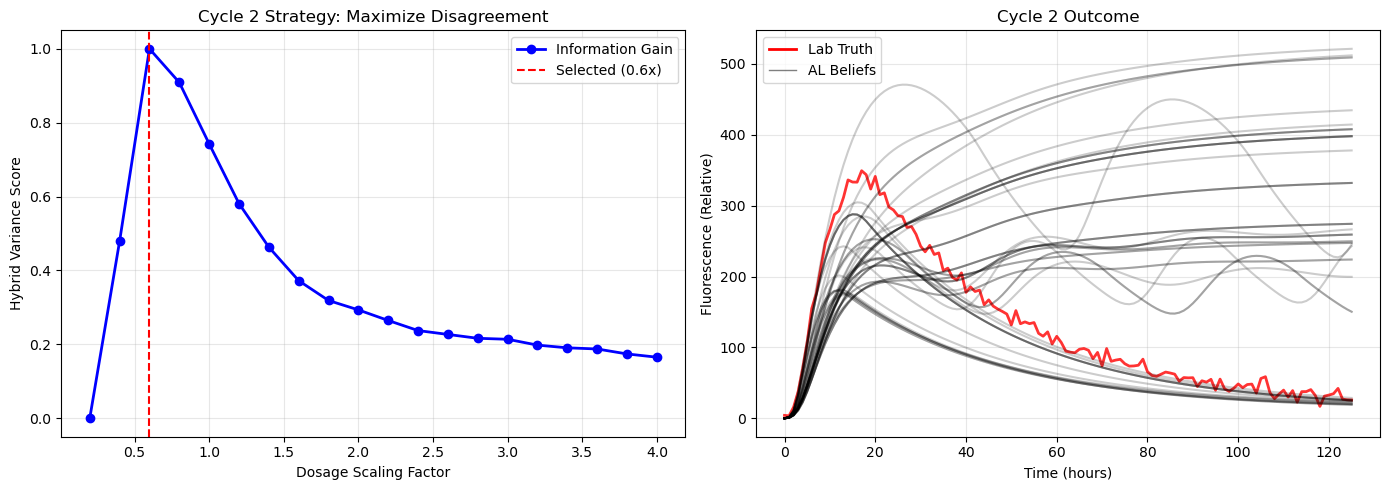

Cycle 3/5: Updating Beliefs...:  40%|████      | 2/5 [20:13<20:48, 416.08s/it]


>> Cycle 3: Requesting Dosage 0.4x (Max Disagreement)
   [Learner] Assessing 200 parameter sets against experimental data...
   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.3357e-04


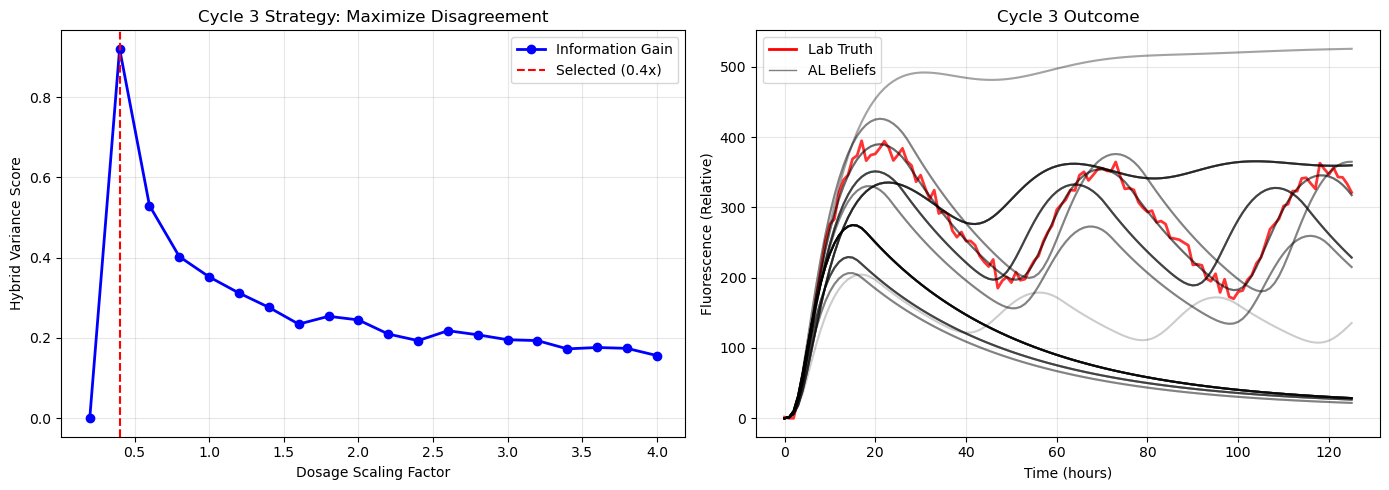

Cycle 4/5: Updating Beliefs...:  60%|██████    | 3/5 [27:11<13:45, 412.92s/it]


>> Cycle 4: Requesting Dosage 0.4x (Max Disagreement)
   [Learner] Assessing 200 parameter sets against experimental data...
   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.7704e-04


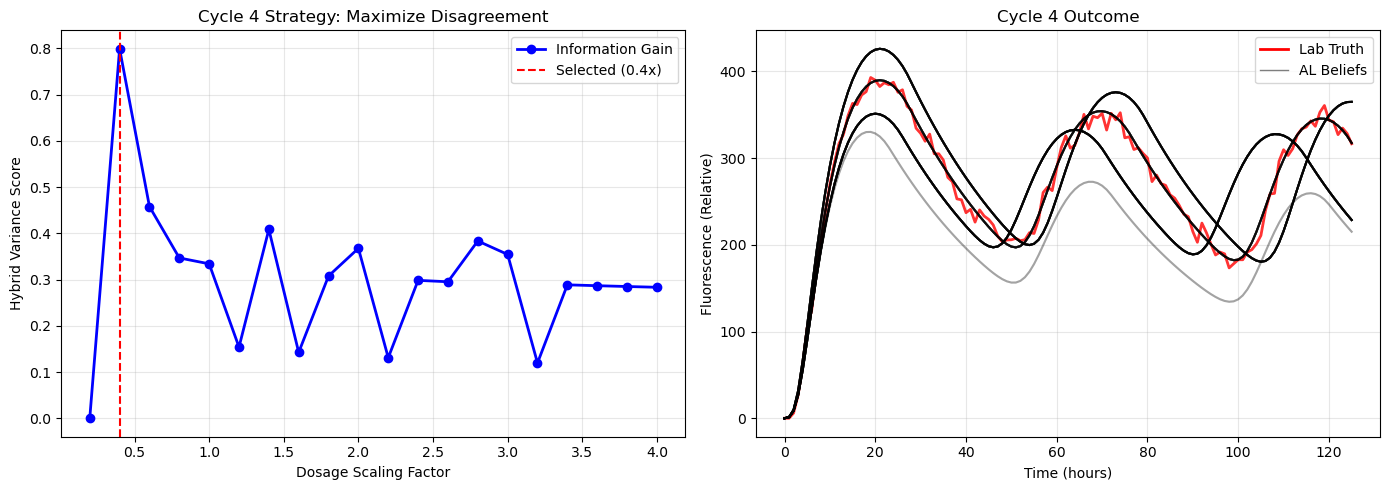

Cycle 5/5: Updating Beliefs...:  80%|████████  | 4/5 [34:37<07:00, 420.93s/it]


>> Cycle 5: Requesting Dosage 1.6x (Max Disagreement)
   [Learner] Assessing 200 parameter sets against experimental data...
   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.3018e-04


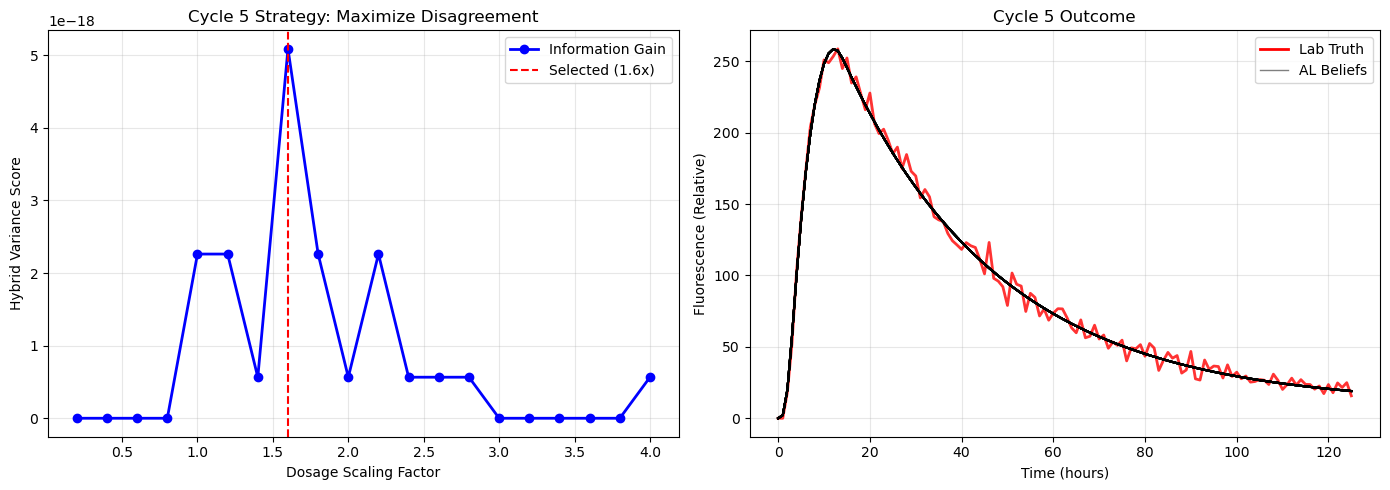

Cycle 5/5: Updating Beliefs...: 100%|██████████| 5/5 [35:06<00:00, 421.31s/it]

>> ACTIVE LEARNING STOPPED.


In [ ]:
# ==========================================
# STEP E: THE ACTIVE LEARNING LOOP
# ==========================================
print("\n>> STARTING ACTIVE LEARNING LOOP...")

# Storage for later analysis/replay
full_history = []

# TQDM Wrapper (Standard Text Bar)
pbar = tqdm(range(N_CYCLES), desc="Active Learning Cycles")

for cycle in pbar:
    # Update progress bar description
    pbar.set_description(f"Cycle {cycle + 1}/{N_CYCLES}: Designing...")
    
    # --- 1. DESIGN ---
    # print(f"   [Designer] Simulating 200 hypotheses across 20 dosages...") 
    best_dose, scores, dosages = designer.design_experiment(current_ensemble, current_promos)
    print(f"\n>> Cycle {cycle+1}: Requesting Dosage {best_dose:.1f}x (Max Disagreement)")
    
    # --- 2. EXPERIMENT ---
    pbar.set_description(f"Cycle {cycle + 1}/{N_CYCLES}: Experimenting...")
    t_exp, y_exp = lab.run_experiment(best_dose)
    
    # --- 3. UPDATE ---
    pbar.set_description(f"Cycle {cycle + 1}/{N_CYCLES}: Updating Beliefs...")
    new_ensemble, new_promos = learner.update_belief(
        current_ensemble, current_promos, 
        best_dose, t_exp, y_exp
    )
    
    # --- 4. SAVE HISTORY (Checkpoint) ---
    cycle_snapshot = {
        'cycle': cycle,
        'best_dose': best_dose,
        'scores': scores,
        'dosages': dosages,
        'lab_data': (t_exp, y_exp),
        'ensemble_snapshot': current_ensemble, # Save the BEFORE update state or AFTER
        'updated_ensemble': new_ensemble
    }
    full_history.append(cycle_snapshot)
    
    # Save to disk immediately (so we can inspect even if loop crashes or we interrupt)
    filename = f"al_history_cycle_{cycle+1}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(cycle_snapshot, f)
    # print(f"   [System] Saved snapshot to {filename}")
    
    # --- 5. VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: The "Why" (Variance Landscape)
    axes[0].plot(dosages, scores, 'b-o', linewidth=2, label='Information Gain')
    axes[0].axvline(best_dose, color='r', linestyle='--', label=f'Selected ({best_dose:.1f}x)')
    axes[0].set_title(f"Cycle {cycle+1} Strategy: Maximize Disagreement")
    axes[0].set_xlabel("Dosage Scaling Factor")
    axes[0].set_ylabel("Hybrid Variance Score")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: The "Result" (Belief vs Truth)
    # Plot Truth
    axes[1].plot(t_exp, y_exp, 'r-', linewidth=2, label='Lab Data (Truth)', alpha=0.8)
    
    # Plot Beliefs (Subset)
    from scipy.integrate import odeint
    from circuits_miner.get_system_equations_pop import system_equations_DsRed_pop
    
    # Temp topo for plotting
    sim_dose = {k: v * best_dose for k, v in target_circuit.dose.items() if k != 'Rep'}
    if 'Rep' in target_circuit.dose: sim_dose['Rep'] = target_circuit.dose['Rep']
    
    TopoClass = type(target_circuit)
    plot_topo = TopoClass(target_circuit.edge_list, sim_dose, target_circuit.promo_node)
    
    subset_size = min(50, len(current_ensemble))
    indices = np.random.choice(len(current_ensemble), subset_size, replace=False)
    
    for i in indices:
        y_pred = odeint(
            system_equations_DsRed_pop,
            np.zeros(plot_topo.num_states * 2),
            t_exp,
            args=('on', np.ones(5), plot_topo, current_promos[i], current_ensemble[i])
        )[:, -1] # / (lab.ref_val + 1e-9)
        
        # Ghost traces (Black = Current Belief)
        axes[1].plot(t_exp, y_pred, 'k-', alpha=0.2)

    axes[1].set_title(f"Cycle {cycle+1} Outcome")
    axes[1].set_xlabel("Time (hours)")
    axes[1].set_ylabel("Fluorescence (Relative)")
    
    # Custom Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=2),
                    Line2D([0], [0], color='k', lw=1, alpha=0.5)]
    axes[1].legend(custom_lines, ['Lab Truth', 'AL Beliefs'])
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Update for next cycle
    current_ensemble = new_ensemble
    current_promos = new_promos

print(">> ACTIVE LEARNING STOPPED.")

>> VALIDATING FINAL BELIEF STATE...


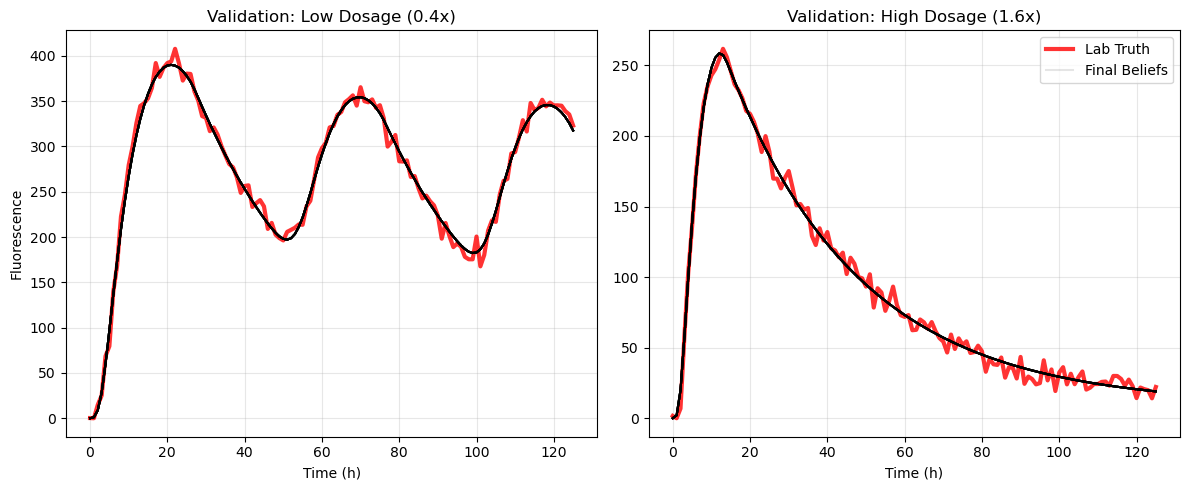

In [8]:
# THE BIFURCATION VALIDATION

print(">> VALIDATING FINAL BELIEF STATE...")

# 1. SETUP PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---------------------------------------------
# PANEL A: LOW DOSAGE (0.4x) -> SHOULD WIGGLE
# ---------------------------------------------
test_dose_low = 0.4
t_low, y_low_truth = lab.run_experiment(test_dose_low)

# Simulate Beliefs at 0.4x
sim_dose_low = {k: v * test_dose_low for k, v in target_circuit.dose.items() if k != 'Rep'}
if 'Rep' in target_circuit.dose: sim_dose_low['Rep'] = target_circuit.dose['Rep']
TopoClass = type(target_circuit)
topo_low = TopoClass(target_circuit.edge_list, sim_dose_low, target_circuit.promo_node)

axes[0].plot(t_low, y_low_truth, 'r-', linewidth=3, label='Lab Truth', alpha=0.8)

# Plot 50 Random Survivors
subset_indices = np.random.choice(len(current_ensemble), min(50, len(current_ensemble)), replace=False)
from scipy.integrate import odeint
from circuits_miner.get_system_equations_pop import system_equations_DsRed_pop

for i in subset_indices:
    y_pred = odeint(
        system_equations_DsRed_pop,
        np.zeros(topo_low.num_states * 2),
        t_low,
        args=('on', np.ones(5), topo_low, current_promos[i], current_ensemble[i])
    )[:, -1]
    axes[0].plot(t_low, y_pred, 'k-', alpha=0.1)

axes[0].set_title(f"Validation: Low Dosage ({test_dose_low}x)")
axes[0].set_ylabel("Fluorescence")
axes[0].set_xlabel("Time (h)")
axes[0].grid(True, alpha=0.3)

# ---------------------------------------------
# PANEL B: HIGH DOSAGE (1.6x) -> SHOULD PULSE
# ---------------------------------------------
test_dose_high = 1.6
t_high, y_high_truth = lab.run_experiment(test_dose_high)

# Simulate Beliefs at 1.6x
sim_dose_high = {k: v * test_dose_high for k, v in target_circuit.dose.items() if k != 'Rep'}
if 'Rep' in target_circuit.dose: sim_dose_high['Rep'] = target_circuit.dose['Rep']
topo_high = TopoClass(target_circuit.edge_list, sim_dose_high, target_circuit.promo_node)

axes[1].plot(t_high, y_high_truth, 'r-', linewidth=3, label='Lab Truth', alpha=0.8)

for i in subset_indices:
    y_pred = odeint(
        system_equations_DsRed_pop,
        np.zeros(topo_high.num_states * 2),
        t_high,
        args=('on', np.ones(5), topo_high, current_promos[i], current_ensemble[i])
    )[:, -1]
    axes[1].plot(t_high, y_pred, 'k-', alpha=0.1)

axes[1].set_title(f"Validation: High Dosage ({test_dose_high}x)")
axes[1].set_xlabel("Time (h)")
axes[1].legend(['Lab Truth', 'Final Beliefs'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

